This is Part III of the notebook with some experiments in using the Yamnet pre-trained neural network for classifying and evaluating bird audio recordings from the Cacophony project.

See [part I](Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for a full background


Note that based on the results obtained in [part V](Yamnet_Audio_Classification_Experiments_Part_5.ipynb)
<b> no bandpass filtering </b> was used on the input 


Quentin McDonald <br>
September  2021

In [8]:
import csv
import io
import os
import os.path
import glob
import datetime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('seaborn')

from matplotlib import patches
from IPython import display
import pydub
from scipy import signal
import pandas as pd
from tqdm import notebook,trange
import pickle

# Common code moved to utils:
import utils

import score

In [9]:
SAMPLE_RATE = 16000 # Work at 16000 sampling rate
LOW_PASS_CUTOFF = None
HIGH_PASS_CUTOFF = None
BIRDS_CLASSES = utils.BIRDS_CLASSES

In [10]:
model,class_names = utils.load_model_and_class_names()

<H2> Larger scale testing </H2>

Looking at scoring for all data recorded from the device at my place

In [11]:
def read_cacophony_scores(meta_data_filename):
    """
    Given a CSV file with the meta data in it, read the file and return a dictionary where the keys are the 
    recording IDs and the values are the mean Cacaphony index for the recording
    
    """
    
    cacophony_dict = {}
    
    if os.path.exists(meta_data_filename):
        with open(meta_data_filename) as f:
            recordings_file = csv.DictReader(f)
            for row in recordings_file:
                row_id = int(row["ID"])
                ci = row["Cacophony Index"]
                cis = ci.split(";")
                # Average the first two values:
                cacophony_dict[row_id] = ((float(cis[0])+float(cis[1]))/2.0)

                
    return cacophony_dict

    

In [12]:
def generate_scores_for_directory(directory, model, bird_classes, low_pass_cutoff=None, high_pass_cutoff=None,
                            score_threshold=0.4, top_k_scores = 3,  num_offsets=3, sample_rate=16000,
                                  meta_data_filename = None):
    """
    Generate Yamnet based scores for all the audio files in directory, using the low_pass cutoff and high_pass
    cutoff if they exist. 
    num_offets, score_threshold and top_k_scores are used to control the scoring (see score.score_audio_file())
    
    If a meta data CSV file is specified then the cacophony scores will be read from that. 
    
    Will return a tuple of numpy arrays: (dates, ids, top_class_scores, threshold_scores, cacophony_scores)
    
    """
    
    files = sorted(glob.glob("{}/*.mp4".format(directory)))
    threshold_scores = []
    top_class_scores = []
    dates = []
    ids = []
    caco_scores = []
    
    if meta_data_filename is not None:
        caco_dict = read_cacophony_scores(os.path.join(directory,meta_data_filename))
        
    for i in trange(len(files), ascii=True):
        f = files[i]
        
        top_class_score, threshold_score = score.score_audio_file(f,model=model, bird_classes =bird_classes, 
                                                                  num_offsets = num_offsets, 
                                                                  low_pass_cutoff=low_pass_cutoff, 
                                                               high_pass_cutoff=high_pass_cutoff, 
                                                                  score_threshold=score_threshold, 
                                                                  top_k_scores=top_k_scores,
                                                               sample_rate=sample_rate)
        
       
        #filenames have format <ID>-<DEVICE_NAME>-<YYYYMMDD>-<HHMMSS>.mp4
        # use split to break apart the fields
        fields = f[len(directory):].split("-")
        file_id = int(fields[0])
        if meta_data_filename is not None:
            if file_id not in caco_dict:
                continue   # Skip files that don't have cacophony indices
            else:
                caco_scores.append(caco_dict[file_id])
        
        top_class_scores.append(top_class_score)
        threshold_scores.append(threshold_score)
        
        
       
        ids.append(file_id)
        dates.append(utils.filename_to_date(fields[2]+"-" + fields[3]))
        
        
       
    
    return (np.array(ids),np.array(dates),np.array(top_class_scores),np.array(threshold_scores), 
            np.array(caco_scores))
        
    
    

In [13]:
(ids, dates, top_class_scores, threshold_scores, caco_scores) = generate_scores_for_directory("larger_datasets/qtest_data/", model, BIRDS_CLASSES, num_offsets = 3, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
                             top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "qtest_meta.csv")

scores_obj = (ids, dates, top_class_scores, threshold_scores, caco_scores)
with open("larger_datasets/qtest_data/scores.pickle","wb") as f:
    pickle.dump(scores_obj,f)

100%|#######################################| 1122/1122 [14:53<00:00,  1.26it/s]


In [14]:
with open("larger_datasets/qtest_data/scores.pickle","rb") as f:
    (ids, dates, top_class_scores, threshold_scores, caco_scores) = pickle.load(f)

In [15]:
# Compare 5 offsets with 3 offsets:
(ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off) = generate_scores_for_directory(
    "larger_datasets/qtest_data/", model, BIRDS_CLASSES, num_offsets = 5, low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, 
    score_threshold=0.4, top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "qtest_meta.csv")


scores_obj_5off = (ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off)
with open("larger_datasets/qtest_data/scores_5off.pickle","wb") as f:
    pickle.dump(scores_obj_5off,f)

100%|#######################################| 1122/1122 [22:11<00:00,  1.19s/it]


In [16]:
with open("larger_datasets/qtest_data/scores_5off.pickle","rb") as f:
    (ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off) = pickle.load(f)

In [17]:
def plot_compare_scores( score1, score2, title="", xlabel="", ylabel="", show_45_line=False, 
                        show_regression_line=False):
    """
    Plot a scatter plot of the scores in score1 and score2
    
    Will draw 45 degree (x==y) line if show_45_line is True
    """
    
    fig = plt.figure(2,figsize=(8,8))
    ax = fig.subplots(1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.scatter(score1,score2, marker='o', c="#338833")
    if show_45_line:
        ax.axline([0, 0], [1, 1],linewidth=1,c="#DD6666")
    if show_regression_line:
        m, b = np.polyfit(score1, score2, 1)
        x = np.array(score1)
        plt.plot(x, x*m + b, linewidth=2, c="#DDDD33")
        title = title + "\nFit line {:.3f}x + {:.3f}".format(m,b)
        
    ax.set_title(title)
    plt.show()


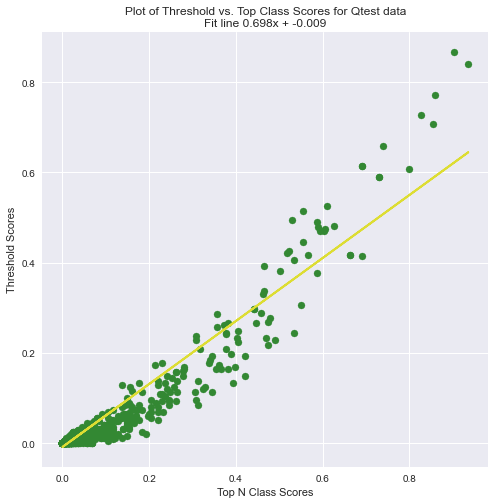

In [18]:
plot_compare_scores(top_class_scores,threshold_scores,"Plot of Threshold vs. Top Class Scores for Qtest data",
                   "Top N Class Scores", "Threshold Scores",show_45_line=False,show_regression_line = True )

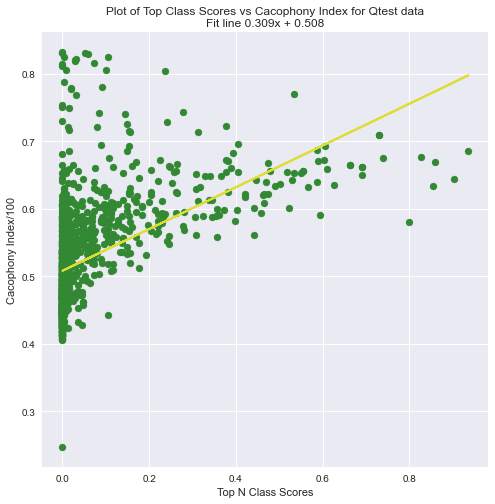

In [19]:
caco_frac = caco_scores/100.0
plot_compare_scores(top_class_scores,caco_frac,"Plot of Top Class Scores vs Cacophony Index for Qtest data",
                   "Top N Class Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

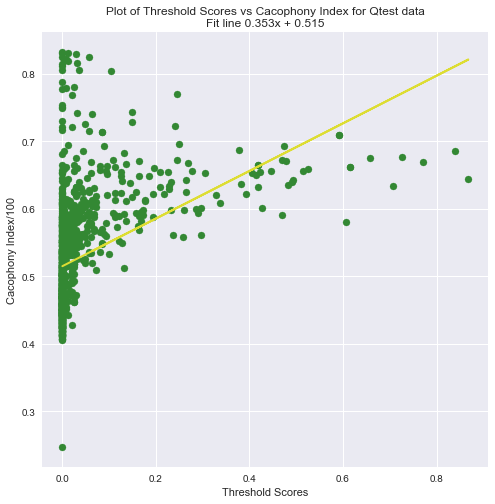

In [20]:

plot_compare_scores(threshold_scores,caco_frac,"Plot of Threshold Scores vs Cacophony Index for Qtest data",
                   "Threshold Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

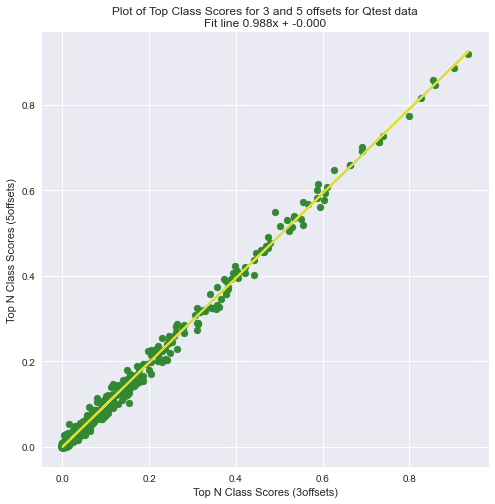

In [21]:
# Effect of number of offsets:
plot_compare_scores(top_class_scores,top_class_scores_5off,"Plot of Top Class Scores for 3 and 5 offsets for Qtest data",
                   "Top N Class Scores (3offsets)", "Top N Class Scores (5offsets)",show_45_line=False,show_regression_line = True )

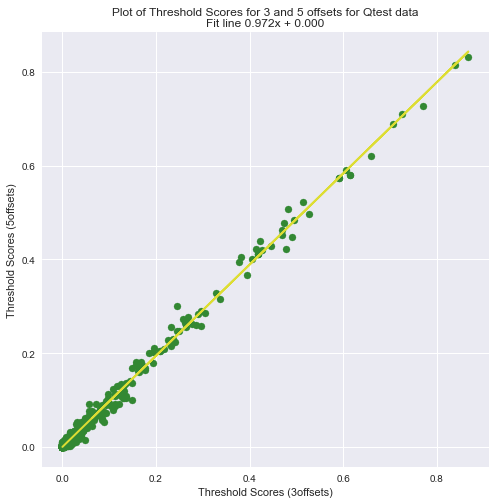

In [22]:
plot_compare_scores(threshold_scores,threshold_scores_5off,"Plot of Threshold Scores for 3 and 5 offsets for Qtest data",
                   "Threshold Scores (3offsets)", "Threshold Scores (5offsets)",show_45_line=False,show_regression_line = True )

<H3> Top Scores by Each Method </H3>
Examine audio files giving the top scores for each method

In [23]:
def print_top_k_scores(scores,k, ids, dates, title="", alt=None,alt_title=""):
    """
    For bird scores in "scores", print a record of the top-K scores, including links to the recording
    based on data in ids and dates
    """
    idx = np.argsort(-scores)[:k]
    
    print(title)
    print()
    if alt is None:
        print("{:20s} {:5s}     {:50s}".format("Date","Score","Link"))
        print("{:20s}-{:5s}-----{:50s}".format("-"*20,"-"*5,"-"*60))
    else:
        print("{:20s} {:5s}     {:50s} {:10s}".format("Date","Score","Link",alt_title))
        print("{:20s}-{:5s}-----{:50s}".format("-"*20,"-"*5,"-"*70))
    for i in idx:
            date = dates[i].strftime("%d-%b-%Y %H:%M:%S")
            link = "https://browse.cacophony.org.nz/recording/{}".format(ids[i])
            if alt is None:
                print("{:20s} {:5.2f}     {:40s}".format(date, scores[i], link))
            else:
                print("{:20s} {:5.2f}     {:40s}   {:5.2f}".format(date, scores[i], link, alt[i]))
    

In [24]:
NUM_TOP = 10
print_top_k_scores(top_class_scores, NUM_TOP, ids,dates,"Top N Class Scores for QTest", caco_scores,"CI")

Top N Class Scores for QTest

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
08-Sep-2021 07:27:47  0.94     https://browse.cacophony.org.nz/recording/932245   68.55
28-Aug-2021 07:44:51  0.90     https://browse.cacophony.org.nz/recording/923452   64.45
13-Sep-2021 16:07:01  0.86     https://browse.cacophony.org.nz/recording/936985   66.90
15-Sep-2021 06:28:18  0.86     https://browse.cacophony.org.nz/recording/937963   63.35
15-Sep-2021 10:56:33  0.83     https://browse.cacophony.org.nz/recording/938067   67.65
11-Sep-2021 13:15:02  0.80     https://browse.cacophony.org.nz/recording/935696   58.00
08-Sep-2021 16:19:46  0.74     https://browse.cacophony.org.nz/recording/932749   67.50
08-Sep-2021 16:23:29  0.73     https://browse.cacophony.org.nz/recording/932750   71.00
08-Sep-2021 16:23:29  0.73     https://browse.cacophony.org.nz/recordin

In [25]:
print_top_k_scores(threshold_scores, NUM_TOP, ids,dates,"Top Threshold Scores for QTest", caco_scores, "CI")

Top Threshold Scores for QTest

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
28-Aug-2021 07:44:51  0.87     https://browse.cacophony.org.nz/recording/923452   64.45
08-Sep-2021 07:27:47  0.84     https://browse.cacophony.org.nz/recording/932245   68.55
13-Sep-2021 16:07:01  0.77     https://browse.cacophony.org.nz/recording/936985   66.90
15-Sep-2021 10:56:33  0.73     https://browse.cacophony.org.nz/recording/938067   67.65
15-Sep-2021 06:28:18  0.71     https://browse.cacophony.org.nz/recording/937963   63.35
08-Sep-2021 16:19:46  0.66     https://browse.cacophony.org.nz/recording/932749   67.50
10-Sep-2021 06:10:00  0.61     https://browse.cacophony.org.nz/recording/934648   66.20
10-Sep-2021 06:10:00  0.61     https://browse.cacophony.org.nz/recording/934634   66.20
11-Sep-2021 13:15:02  0.61     https://browse.cacophony.org.nz/record

In [26]:
print_top_k_scores(caco_scores, NUM_TOP, ids,dates,"Top Cacophony Index Scores for QTest", threshold_scores,"Thresh")

Top Cacophony Index Scores for QTest

Date                 Score     Link                                               Thresh    
-----------------------------------------------------------------------------------------------------
13-Sep-2021 05:13:05 83.30     https://browse.cacophony.org.nz/recording/936726    0.00
13-Sep-2021 05:56:51 83.15     https://browse.cacophony.org.nz/recording/936738    0.00
13-Sep-2021 05:54:16 83.10     https://browse.cacophony.org.nz/recording/936734    0.01
14-Sep-2021 10:19:02 83.00     https://browse.cacophony.org.nz/recording/937435    0.03
02-Sep-2021 09:30:21 82.50     https://browse.cacophony.org.nz/recording/926656    0.00
14-Sep-2021 10:13:04 82.50     https://browse.cacophony.org.nz/recording/937424    0.06
14-Sep-2021 01:14:09 82.20     https://browse.cacophony.org.nz/recording/937214    0.01
13-Sep-2021 06:48:53 82.00     https://browse.cacophony.org.nz/recording/936760    0.00
14-Sep-2021 05:15:43 81.90     https://browse.cacophony.org.nz/

<H3> Averaging scores per hour of the day over the whole dataset </H3>


In [27]:

def plot_average_per_hour_score( dates, class_scores, threshold_scores, cacophony_scores, title=""):
    """
    Create a plot of the mean score for each hour of the day over the entire dataset
    
    
    """
    
    class_data = []
    threshold_data = []
    caco_data = []
    for i in range(24):
        class_data.append([])
        threshold_data.append([])
        caco_data.append([])
    
  
    for i,d in enumerate(dates):
        hour = d.hour
        class_data[hour].append(class_scores[i])
        threshold_data[hour].append(threshold_scores[i])
        caco_data[hour].append(cacophony_scores[i])
     
    class_data_mean = np.zeros((24,), dtype='float')
    thresh_data_mean = np.zeros((24,), dtype='float')
    caco_data_mean = np.zeros((24,), dtype='float')
    class_data_sd = np.zeros((24,), dtype='float')
    thresh_data_sd = np.zeros((24,), dtype='float')
    caco_data_sd = np.zeros((24,), dtype='float')
    hours = []
    for i in range(24):
        hours.append(i)
        class_data_mean[i] = np.mean(np.array(class_data[i]))
        thresh_data_mean[i] = np.mean(np.array(threshold_data[i]))
        caco_data_mean[i] = np.mean(np.array(caco_data[i]))
      
    
    fig = plt.figure(2,figsize=(15,10),dpi=300)
    ax = fig.subplots(1)
    ax.set_title(title)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Score")
    ax.xaxis.set_major_locator(MultipleLocator(3))
    lns1=ax.plot(hours,class_data_mean,c='#AA55AA',linewidth=3,label='Class Score',marker='o')
    lns2=ax.plot(hours,thresh_data_mean,c='#55AAAA',linewidth=3,label='Threshold Score',marker='o')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    lns3 = ax2.plot(hours,caco_data_mean,c='#AAAA55',linewidth=3,label='Cacophony Index',marker='o')
    ax2.set_ylabel("Cacophony Index")
        
    lns = lns1+lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    plt.show()
    

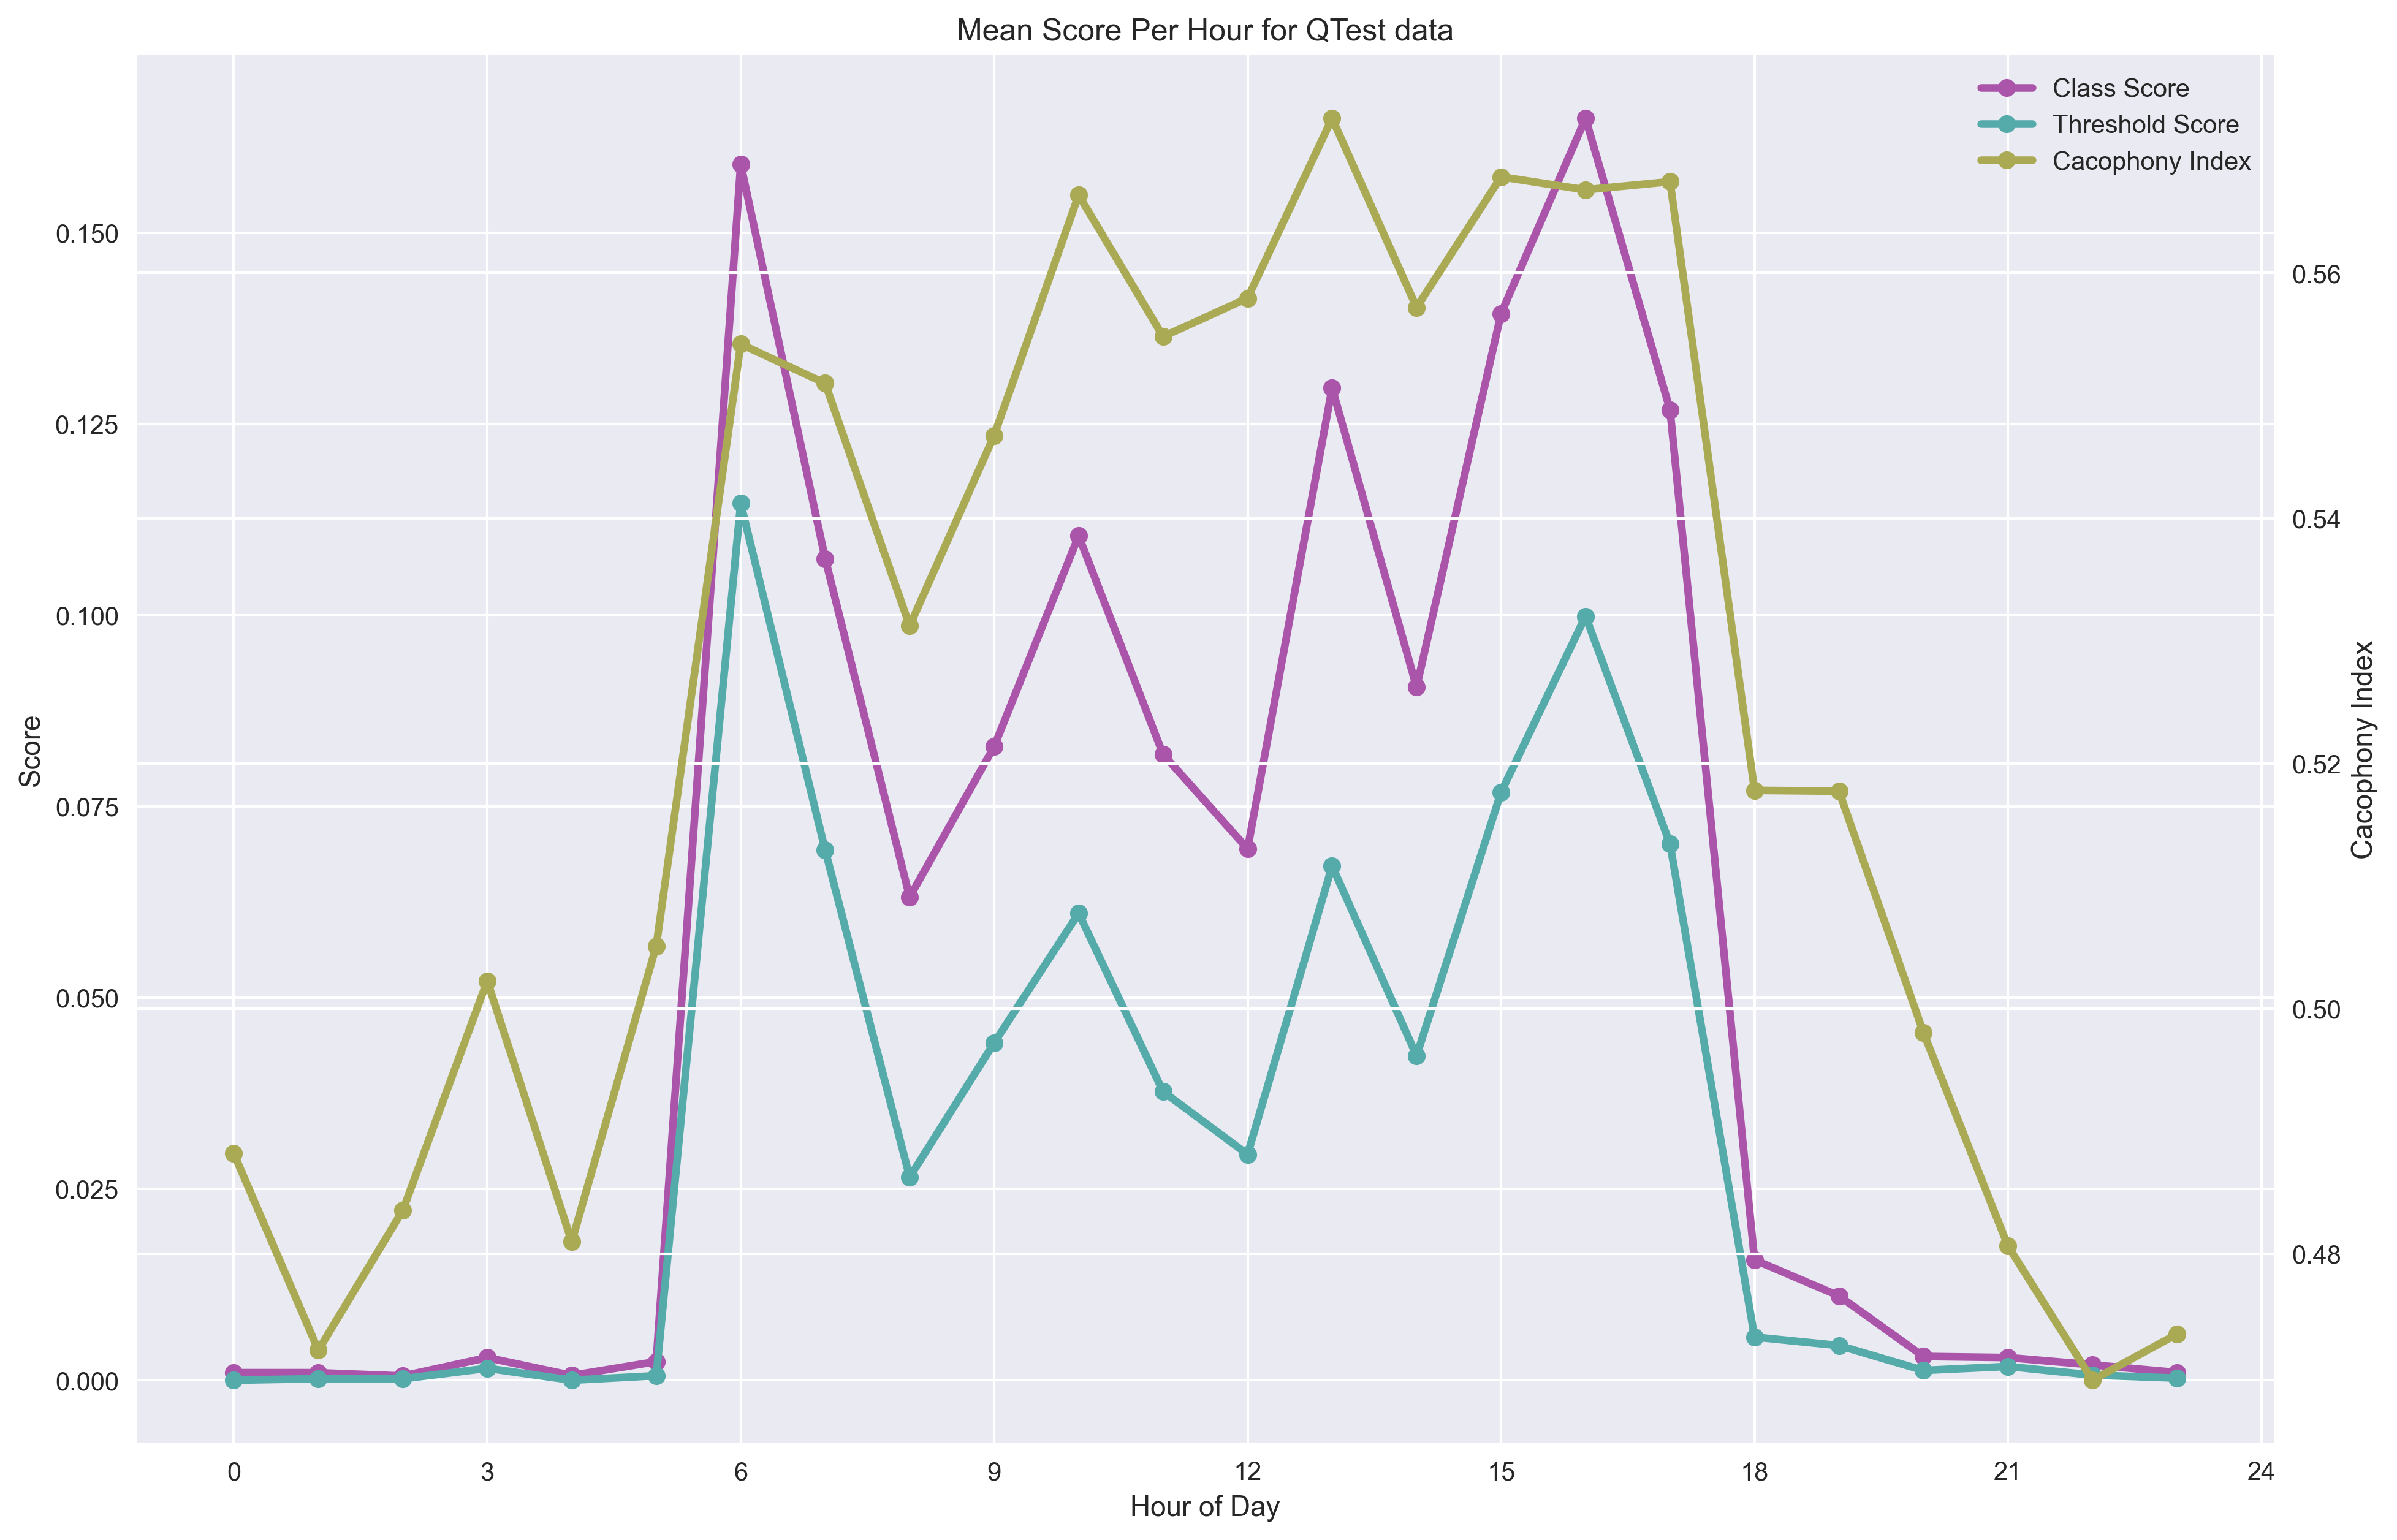

In [28]:
plot_average_per_hour_score(dates, top_class_scores, threshold_scores, caco_frac,
                           title= "Mean Score Per Hour for QTest data")

  <H3> Similar analysis with data from Grant's Shed for August 2021 </H3>

In [29]:
(gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores, 
 gs_aug21_threshold_scores, gs_aug21_caco_scores) = generate_scores_for_directory("larger_datasets/gs_aug21/", model, BIRDS_CLASSES, num_offsets = 3, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
                             top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "gs_aug21_meta.csv")

scores_obj = (gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores, 
 gs_aug21_threshold_scores, gs_aug21_caco_scores)
with open("larger_datasets/gs_aug21/scores.pickle","wb") as f:
    pickle.dump(scores_obj,f)

100%|#######################################| 1070/1070 [13:17<00:00,  1.34it/s]


In [30]:
with open("larger_datasets/gs_aug21/scores.pickle","rb") as f:
    (gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores,gs_aug21_threshold_scores, 
     gs_aug21_caco_scores) = pickle.load(f)

gs_aug21_caco_frac = gs_aug21_caco_scores/100.0

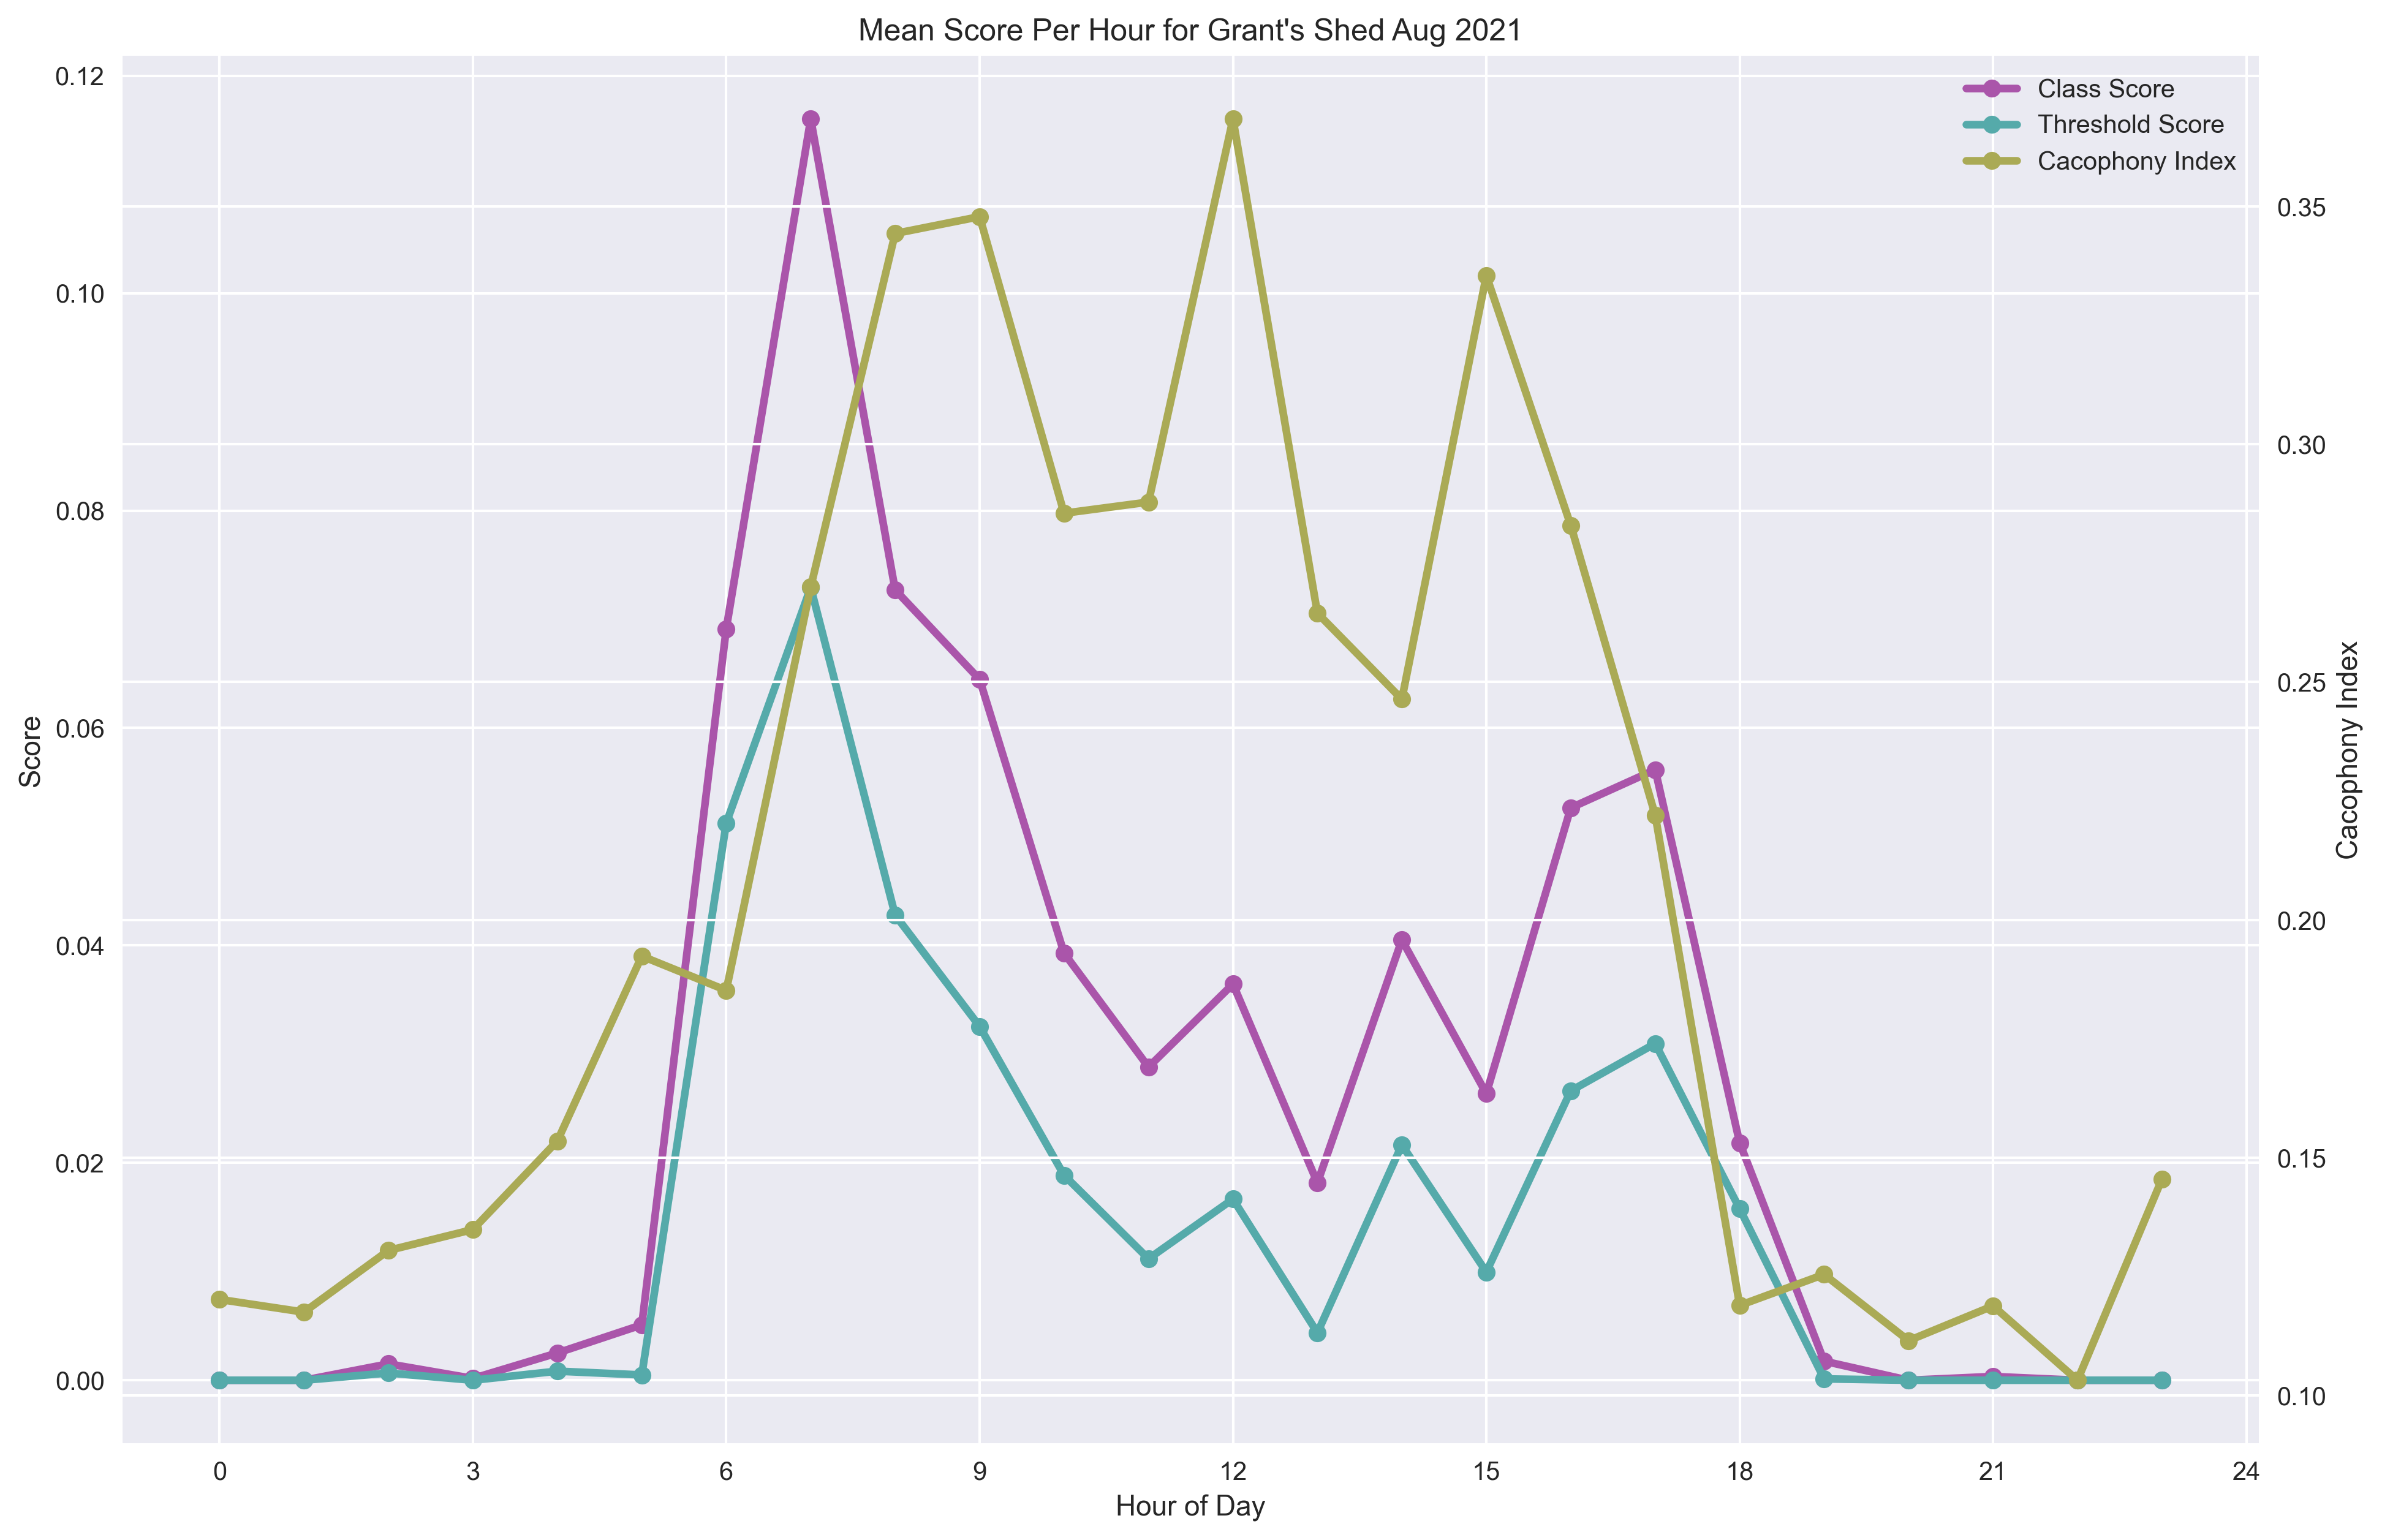

In [31]:

plot_average_per_hour_score(gs_aug21_dates, gs_aug21_top_class_scores, gs_aug21_threshold_scores, gs_aug21_caco_frac,
                           title= "Mean Score Per Hour for Grant's Shed Aug 2021")

In [32]:
print_top_k_scores(gs_aug21_top_class_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,
                   "Top N Class Scores for Grant's Shed Aug 2021", gs_aug21_caco_scores, "CI")

Top N Class Scores for Grant's Shed Aug 2021

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
24-Aug-2021 06:41:00  0.98     https://browse.cacophony.org.nz/recording/921124   64.80
22-Aug-2021 07:17:04  0.97     https://browse.cacophony.org.nz/recording/919540   64.50
24-Aug-2021 07:35:13  0.96     https://browse.cacophony.org.nz/recording/921129   62.05
22-Aug-2021 06:45:00  0.95     https://browse.cacophony.org.nz/recording/919537   65.30
23-Aug-2021 06:57:03  0.92     https://browse.cacophony.org.nz/recording/920234   68.70
23-Aug-2021 06:43:00  0.91     https://browse.cacophony.org.nz/recording/920233   65.05
21-Aug-2021 07:06:00  0.88     https://browse.cacophony.org.nz/recording/918579   63.75
20-Aug-2021 07:08:00  0.86     https://browse.cacophony.org.nz/recording/917640   70.95
21-Aug-2021 06:57:03  0.86     https://browse.cacophony

In [33]:
print_top_k_scores(gs_aug21_threshold_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,
                   "Top Threshold Scores for Grant's Shed Aug 2021", gs_aug21_caco_scores,"CI" )

Top Threshold Scores for Grant's Shed Aug 2021

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
24-Aug-2021 06:41:00  0.92     https://browse.cacophony.org.nz/recording/921124   64.80
22-Aug-2021 06:45:00  0.90     https://browse.cacophony.org.nz/recording/919537   65.30
22-Aug-2021 07:17:04  0.89     https://browse.cacophony.org.nz/recording/919540   64.50
24-Aug-2021 07:35:13  0.88     https://browse.cacophony.org.nz/recording/921129   62.05
23-Aug-2021 06:57:03  0.83     https://browse.cacophony.org.nz/recording/920234   68.70
23-Aug-2021 06:43:00  0.82     https://browse.cacophony.org.nz/recording/920233   65.05
23-Aug-2021 18:19:00  0.75     https://browse.cacophony.org.nz/recording/920722   66.00
23-Aug-2021 07:13:00  0.73     https://browse.cacophony.org.nz/recording/920237   60.20
20-Aug-2021 18:06:00  0.72     https://browse.cacopho

In [34]:
print_top_k_scores(gs_aug21_caco_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,
                   "Top Cacophony Index for Grant's Shed Aug 2021", gs_aug21_threshold_scores, "Thresh")

Top Cacophony Index for Grant's Shed Aug 2021

Date                 Score     Link                                               Thresh    
-----------------------------------------------------------------------------------------------------
06-Aug-2021 08:12:14 79.10     https://browse.cacophony.org.nz/recording/914358    0.00
20-Aug-2021 07:38:01 78.05     https://browse.cacophony.org.nz/recording/917643    0.26
10-Aug-2021 14:42:06 77.20     https://browse.cacophony.org.nz/recording/914556    0.00
10-Aug-2021 13:42:06 77.10     https://browse.cacophony.org.nz/recording/914555    0.04
10-Aug-2021 09:04:09 76.80     https://browse.cacophony.org.nz/recording/914548    0.00
20-Aug-2021 08:49:06 76.70     https://browse.cacophony.org.nz/recording/917645    0.14
04-Aug-2021 12:15:23 74.75     https://browse.cacophony.org.nz/recording/914270    0.01
10-Aug-2021 12:39:19 74.20     https://browse.cacophony.org.nz/recording/914554    0.00
15-Aug-2021 15:35:04 73.30     https://browse.cacophon

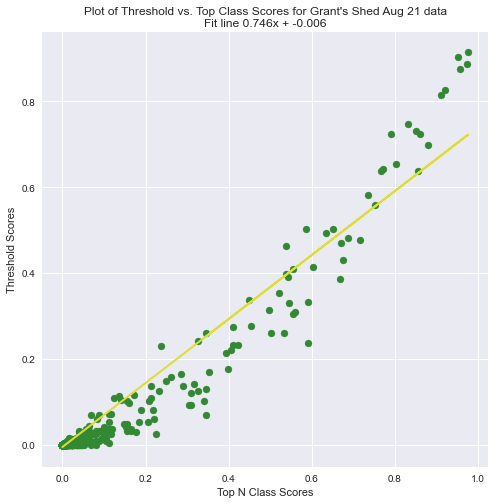

In [35]:
plot_compare_scores(gs_aug21_top_class_scores,gs_aug21_threshold_scores,
                    "Plot of Threshold vs. Top Class Scores for Grant's Shed Aug 21 data",
                   "Top N Class Scores", "Threshold Scores",show_45_line=False,show_regression_line = True )

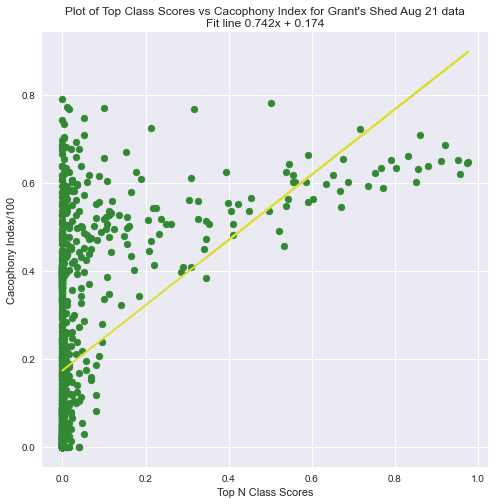

In [36]:
plot_compare_scores(gs_aug21_top_class_scores,gs_aug21_caco_frac,
                    "Plot of Top Class Scores vs Cacophony Index for Grant's Shed Aug 21 data",
                   "Top N Class Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

  <H3> Similar analysis with data from Grant's Shed for Jan 2019 </H3>

In [37]:
(gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
gs_jan19_threshold_scores, gs_jan19_caco_scores) = generate_scores_for_directory("larger_datasets/gs_jan19/", model, BIRDS_CLASSES, num_offsets = 3, 
                             low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
                            top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "gs_jan19_meta.csv")

scores_obj = (gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
 gs_jan19_threshold_scores, gs_jan19_caco_scores)
with open("larger_datasets/gs_jan19/scores.pickle","wb") as f:
    pickle.dump(scores_obj,f)


100%|#######################################| 1319/1319 [16:18<00:00,  1.35it/s]


In [38]:

with open("larger_datasets/gs_jan19/scores.pickle","rb") as f:
    (gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
         gs_jan19_threshold_scores, gs_jan19_caco_scores) = pickle.load(f)

gs_jan19_caco_frac = gs_jan19_caco_scores/100.0

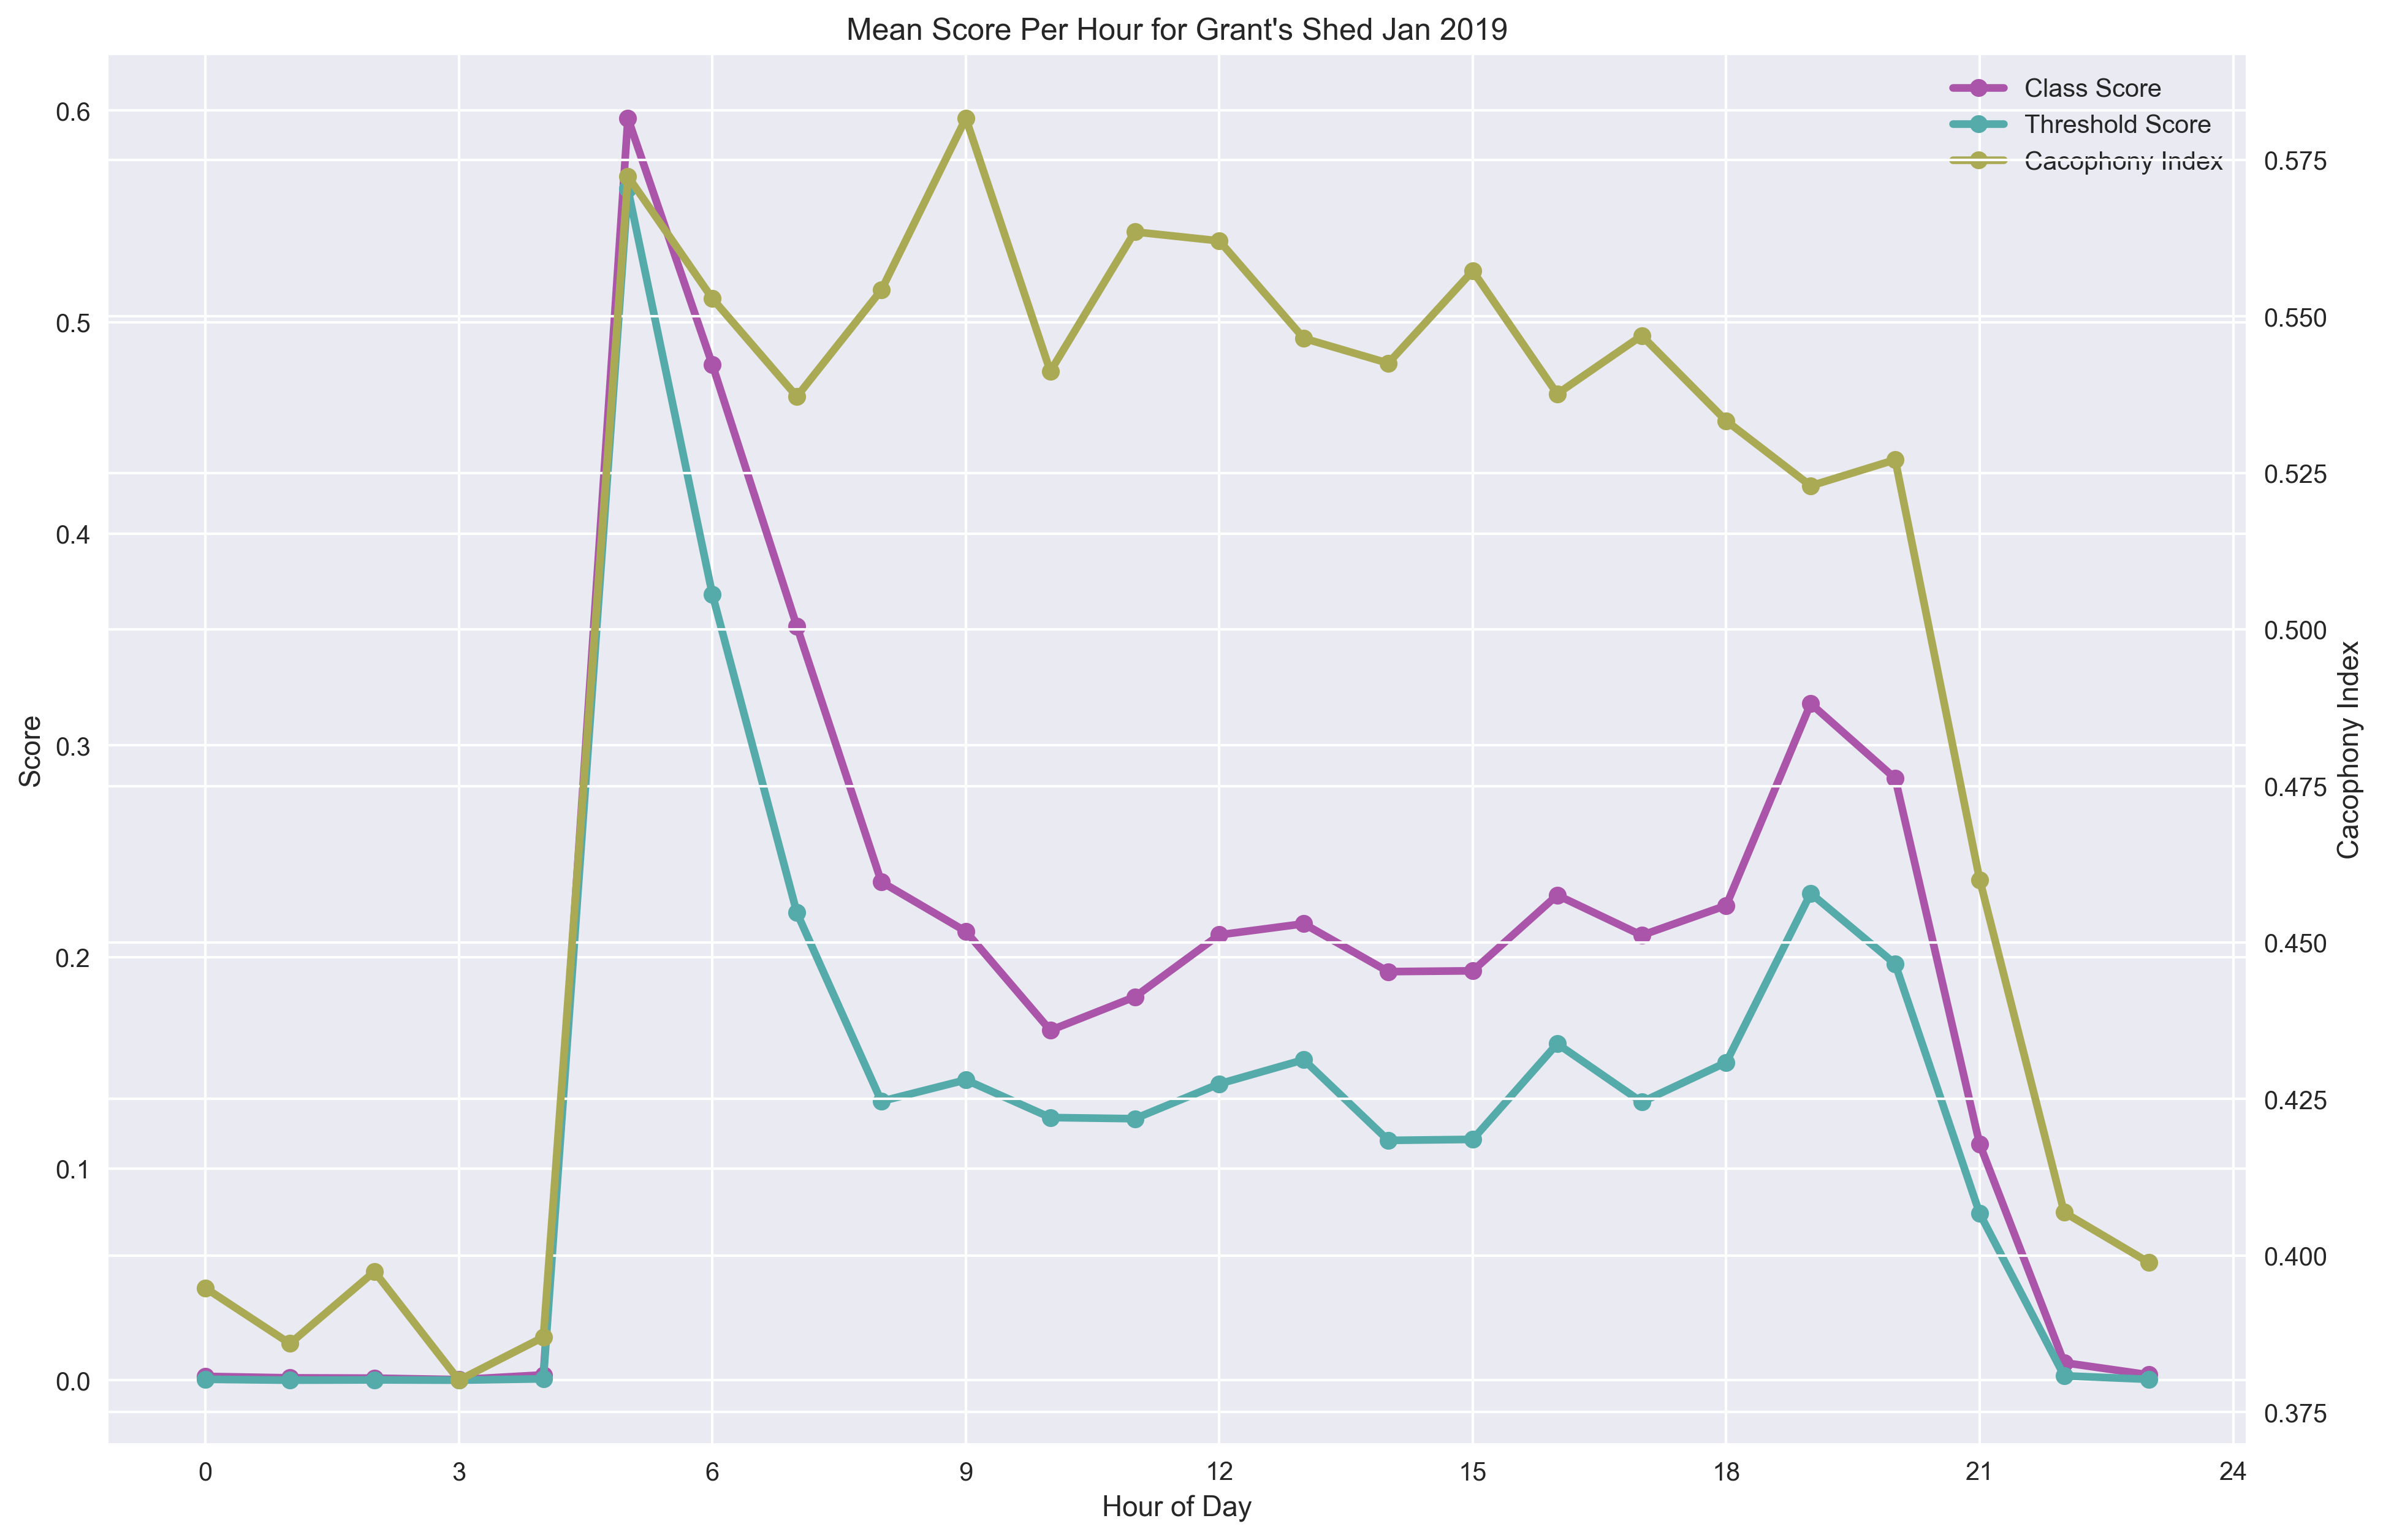

In [39]:
plot_average_per_hour_score(gs_jan19_dates, gs_jan19_top_class_scores, gs_jan19_threshold_scores, 
                            gs_jan19_caco_frac,
                           title= "Mean Score Per Hour for Grant's Shed Jan 2019")

In [40]:
print_top_k_scores(gs_jan19_top_class_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,
                   "Top N Class Scores for Grant's Shed Jan 2019", gs_jan19_caco_scores, "CI")

Top N Class Scores for Grant's Shed Jan 2019

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
12-Jan-2019 05:51:00  0.99     https://browse.cacophony.org.nz/recording/236944   66.65
10-Jan-2019 05:29:42  0.99     https://browse.cacophony.org.nz/recording/236851   68.95
04-Jan-2019 05:33:00  0.99     https://browse.cacophony.org.nz/recording/236582   68.65
02-Jan-2019 05:42:00  0.99     https://browse.cacophony.org.nz/recording/236491   67.10
10-Jan-2019 05:49:00  0.99     https://browse.cacophony.org.nz/recording/236853   68.70
02-Jan-2019 05:24:00  0.99     https://browse.cacophony.org.nz/recording/236489   67.75
02-Jan-2019 05:12:00  0.99     https://browse.cacophony.org.nz/recording/236488   69.00
21-Jan-2019 05:50:00  0.99     https://browse.cacophony.org.nz/recording/237350   66.80
06-Jan-2019 05:35:43  0.99     https://browse.cacophony

In [41]:
print_top_k_scores(gs_jan19_threshold_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,
                   "Top Threshold Scores for Grant's Shed Jan 2019", gs_jan19_caco_scores,"CI")

Top Threshold Scores for Grant's Shed Jan 2019

Date                 Score     Link                                               CI        
-----------------------------------------------------------------------------------------------------
07-Jan-2019 05:36:00  0.99     https://browse.cacophony.org.nz/recording/236717   68.40
26-Jan-2019 05:48:00  0.99     https://browse.cacophony.org.nz/recording/237574   69.35
12-Jan-2019 05:33:00  0.99     https://browse.cacophony.org.nz/recording/236942   69.50
12-Jan-2019 05:41:02  0.99     https://browse.cacophony.org.nz/recording/236943   69.45
11-Jan-2019 05:20:00  0.99     https://browse.cacophony.org.nz/recording/236895   67.15
02-Jan-2019 05:12:00  0.99     https://browse.cacophony.org.nz/recording/236488   69.00
05-Jan-2019 05:34:00  0.99     https://browse.cacophony.org.nz/recording/236627   70.35
19-Jan-2019 05:38:00  0.99     https://browse.cacophony.org.nz/recording/237259   70.00
03-Jan-2019 05:03:00  0.99     https://browse.cacopho

In [42]:
print_top_k_scores(gs_jan19_caco_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,
                   "Top Cacophony Index Scores for Grant's Shed Jan 2019", gs_jan19_threshold_scores,"Thresh")

Top Cacophony Index Scores for Grant's Shed Jan 2019

Date                 Score     Link                                               Thresh    
-----------------------------------------------------------------------------------------------------
11-Jan-2019 09:40:03 79.00     https://browse.cacophony.org.nz/recording/236906    0.01
02-Jan-2019 08:32:03 76.55     https://browse.cacophony.org.nz/recording/236498    0.05
26-Jan-2019 06:16:00 74.80     https://browse.cacophony.org.nz/recording/237577    0.92
05-Jan-2019 11:37:19 74.45     https://browse.cacophony.org.nz/recording/236638    0.09
25-Jan-2019 05:55:00 72.55     https://browse.cacophony.org.nz/recording/237530    0.99
11-Jan-2019 17:16:24 72.25     https://browse.cacophony.org.nz/recording/236914    0.19
27-Jan-2019 18:13:32 72.00     https://browse.cacophony.org.nz/recording/237638    0.39
26-Jan-2019 06:06:00 71.85     https://browse.cacophony.org.nz/recording/237576    0.91
24-Jan-2019 15:30:40 71.10     https://browse.c